In [62]:
import os
import wandb

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
# from stable_baselines3.common.env_checker import check_env

import heapq
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import matplotlib.animation as animation
from IPython.display import display, clear_output

In [63]:
l = np.array(np.random.randint(0,5, size=2)).astype('float')
print(l)
print(type(l[0]))

[2. 4.]
<class 'numpy.float64'>


In [107]:
class DGSN_Env(gym.Env):
    def __init__(self, grid_size=10, max_static_obstacles=30, max_dynamic_obstacles=20, max_steps=500):
        super(DGSN_Env, self).__init__()
        self.grid_size = grid_size
        self.boundary_threshold = 0.5
        self.max_static_obstacles = max_static_obstacles
        self.max_dynamic_obstacles = max_dynamic_obstacles
        # self.num_static_obstacles = np.random.randint(1,10)
        # self.num_dynamic_obstacles = np.random.randint(1,21)
        # self.agent_pos = np.array(np.random.uniform(0, self.grid_size, size=2).round(1))
        # self.goal_pos = np.array(np.random.uniform(0, self.grid_size, size=2).round(1))
        self.num_static_obstacles = 30
        self.num_dynamic_obstacles = 20

        self.agent_pos = np.array(np.random.randint(0, self.grid_size, size=2)).astype('float')
        self.goal_pos = np.array(np.random.randint(0, self.grid_size, size=2)).astype('float')
        
        self.dynamic_obstacles = self._init_dynamic_obstacles()
        self.static_obstacles = self._init_static_obstacles()
        
        self.close_call, self.discomfort, self.current_step, self.ep_no = 0, 0, 1, 0
        self.dist_factor = 4
        self.thresh = 1.5
        self.max_steps = max_steps
        self.total_reward = 0
        
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Dict({
            'agent': spaces.Box(low=0, high=grid_size, shape=(2,), dtype=np.float32),
            'dyn_obs': spaces.Box(low=0, high=grid_size, shape=(self.max_dynamic_obstacles, 2), dtype=np.float64),
            'sta_obs': spaces.Box(low=0, high=grid_size, shape=(self.max_static_obstacles, 2), dtype=np.float64)
        })
        
        # wandb.login()
        # wandb.init(project='DGSN_runs')
        
        self.safe = True
        
        # Evaluation Metrics
        self.Avg_Success_Rate = 0
        self.Avg_Collision_Rate, self.ep_collision_rate, self.collision_count = 0, 0, 0
        self.Avg_Min_Time_To_Collision, self.min_time_to_collision = 0, 0
        self.Avg_Wall_Collision_Rate, self.ep_wall_collision_rate, self.wall_collision_count = 0, 0, 0
        self.Avg_Obstacle_Collision_Rate, self.ep_obstacle_collision_rate, self.obstacle_collision_count = 0, 0, 0
        self.Avg_Human_Collision_Rate, self.ep_human_collision_rate, self.human_collision_count = 0, 0, 0

        self.Avg_Timeout = 0
        self.Avg_Path_Length = 0
        self.Avg_Stalled_Time, self.stalled_time = 0, 0

        self.Avg_Group_Inhibition_Rate, self.ep_group_inhibition_rate, self.group_inhibition = 0, 0, 0
        self.Avg_Discomfort, self.ep_discomfort = 0, 0
        self.Avg_Human_Distance, self.ep_human_distance, self.human_distance = 0, 0, 0
        self.Avg_Closest_Human_Distance, self.closest_human_distance = 0, 0
        self.Min_Closest_Human_Distance = 0
        self.goal_reached = 0
        self.timeout = 0

    def _init_static_obstacles(self):
        obstacles = []
        for _ in range(self.num_static_obstacles):
            # obstacles.append(np.random.uniform(0, self.grid_size, size=2).round(1))
            obstacles.append((np.array(np.random.randint(1, self.grid_size, size=2))).astype('float'))
        return obstacles
    
    def _init_dynamic_obstacles(self):
        obstacles = []
        for _ in range(self.num_dynamic_obstacles):
            # start_pos = np.random.uniform(0, self.grid_size, size=2).round(1)
            # end_pos = np.random.uniform(0, self.grid_size, size=2).round(1)
            start_pos = np.array(np.random.randint(0, self.grid_size, size=2)).astype('float')
            end_pos = np.array(np.random.randint(0, self.grid_size, size=2)).astype('float')
            path = self._compute_path(start_pos, end_pos)
            obstacles.append({
                'start': start_pos,
                'end': end_pos,
                'current': start_pos.copy(),
                'angle': np.rad2deg(np.arctan2(self.agent_pos[1] - start_pos[1], self.agent_pos[0] - start_pos[0])).astype('float'),
                'distance': np.linalg.norm(self.agent_pos - start_pos).astype('float'),
                'path': path if path else []
            })
        return obstacles

    def _compute_path(self, start, end):
        def heuristic(a, b):
            return np.linalg.norm(a - b)

        def a_star(start, goal):
            open_set = []
            heapq.heappush(open_set, (0, tuple(start)))
            came_from = {}
            g_score = {tuple(start): 0}
            f_score = {tuple(start): heuristic(start, goal)}

            while open_set:
                _, current = heapq.heappop(open_set)
                current = np.array(current)

                if np.array_equal(current, goal):
                    path = []
                    while tuple(current) in came_from:
                        path.append(current)
                        current = came_from[tuple(current)]
                    path.append(start)
                    path.reverse()
                    return path
                
                val = 0.1
                neighbors = [current + [val, 0], current + [-val, 0], current + [0, val], current + [0, -val]]
                neighbors = [np.clip(neighbor, 0, self.grid_size - 0.5) for neighbor in neighbors]

                for neighbor in neighbors:
                    tentative_g_score = g_score[tuple(current)] + heuristic(current, neighbor)
                    if tuple(neighbor) not in g_score or tentative_g_score < g_score[tuple(neighbor)]:
                        came_from[tuple(neighbor)] = current
                        g_score[tuple(neighbor)] = tentative_g_score
                        f_score[tuple(neighbor)] = tentative_g_score + heuristic(neighbor, goal)
                        heapq.heappush(open_set, (f_score[tuple(neighbor)], tuple(neighbor)))
            return []

        return a_star(start, end)
    
    def step(self, action):
        self.current_step += 1
        previous_agent_pos = self.agent_pos.copy()
        print(f"Agent's Current Position {previous_agent_pos}")
        print(f"Goal Position : {self.goal_pos}")
        
        vel = 0.2
        
        if action == 0:
            self.agent_pos[1] += vel
            print(f"Action Taken : {action} - Up")
        elif action == 1:
            self.agent_pos[1] -= vel
            print(f"Action Taken : {action} - Down")
        elif action == 2:
            self.agent_pos[0] -= vel
            print(f"Action Taken : {action} - Left")
        elif action == 3:
            self.agent_pos[0] += vel
            print(f"Action Taken : {action} - Right")
        elif action == 4:
            self.agent_pos += [vel, vel]
            print(f"Action Taken : {action} - Right-Up")
        elif action == 5:
            self.agent_pos += [-vel, vel]
            print(f"Action Taken : {action} - Left-Up")
        elif action == 6:
            self.agent_pos += [vel, -vel]
            print(f"Action Taken : {action} - Right-Down")
        elif action == 7:
            self.agent_pos += [-vel, -vel]
            print(f"Action Taken : {action} - Left-Down")
        elif action == 8:
            print(f"Action Taken : {action} - Stay Still!")
            self.stalled_time += 1
            pass
        
        self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 0.5)
        print(f"Agent's New Position {self.agent_pos}")
        print(f"Steps taken : {self.current_step}")
        
        for obstacle in self.dynamic_obstacles:
            if len(obstacle['path']) > 1:
                obstacle['current'] = obstacle['path'].pop(0)
            else:
                obstacle['path'] = self._compute_path(obstacle['start'], obstacle['end'])
        
        reward = self._compute_reward(previous_agent_pos)
        
        print(f"#####################################")
        print(f"Reward Obtained : {reward}")
        print(f"#####################################")
        
        self.total_reward += reward
        
        # wandb.log({"Reward" : reward, "Total_Reward" : self.total_reward})
        
        self.done = self._is_done()
        if self.current_step >= self.max_steps:
            self.done = True
            reward -= 2500
            self.timeout += 1
            # wandb.log({"TimeOut" : self.timeout})
            
            # self.reset()
        truncated = False
        
        return self._get_obs(), reward, self.done, truncated, {}
    
    def _compute_reward(self, previous_agent_pos):
        reward_c = 0
        
        if self.safe:
            self.min_time_to_collision += 1
        
        previous_dist_to_goal = np.linalg.norm(previous_agent_pos - self.goal_pos)
        current_dist_to_goal = np.linalg.norm(self.agent_pos - self.goal_pos)
        del_distance = current_dist_to_goal - previous_dist_to_goal
        
        print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% \n")
        print(f"Distance to the Goal : {current_dist_to_goal}")
        print(f"Del_Distance : {del_distance}")
        
        if (del_distance) > 0:
            reward_c -= del_distance*self.dist_factor
        elif (del_distance) == 0:
            reward_c = -2
        else:
            reward_c += (-del_distance)*self.dist_factor*2
            
        print(f"Reward from Del_Dist : {reward_c}")
            
        # Check for collisions with obstacles and boundaries
        for i, obs in enumerate(self.dynamic_obstacles):
            distance = np.linalg.norm(obs['current'] - self.agent_pos)
            self.human_distance += distance
            
            print(f"******************************")
            print(f"Obstacle #{i} Distance : {distance}")
            
            if distance < 3 and distance != 0:  # Define a threshold for collision
                self.closest_human_distance = min(self.closest_human_distance, distance)
                self.close_call += 1
                                
                pen_1 = (10/distance)
                reward_c -= pen_1  # Penalty for colliding with a dynamic obstacle
                print(f"Penalty Obtained : {pen_1}")
        
        print(f"Reward Post Dynamic Manouevres : {reward_c}")
        print(f"******************************")
        
        grouped_obstacles = self._group_dynamic_obstacles()
        for j, group in enumerate(grouped_obstacles):
            group_center = np.mean(group, axis=0)
            if np.linalg.norm(self.agent_pos - group_center) < self.thresh:                
                reward_c -= 50
                
                
                
                self.discomfort += 1
                wandb.log({"Discomfort": self.discomfort})

                
        if any(np.array_equal(self.agent_pos, obs) for obs in self.dynamic_obstacles):
            self.collision_count += 1
            self.human_collision_count += 1
            self.safe = False
            
            reward_c -= 30  # Penalty for colliding with a dynamic obstacle
            print(f"Collided with a Human!!!")
            print(f"Post Human Collision Reward : {reward_c}")
        if any(np.array_equal(self.agent_pos, obs) for obs in self.static_obstacles):
            self.collision_count += 1
            self.obstacle_collision_count += 1
            self.safe = False
            
            reward_c -= 20  # Penalty for colliding with a static obstacle
            print(f"Collided with an obstacle!!!")
            print(f"Post Obstacle Collision Reward : {reward_c}")
        
        if np.any(self.agent_pos <= self.boundary_threshold) or np.any(self.agent_pos >= self.grid_size - self.boundary_threshold):
            reward_c -= -15 # Penalty for travelling close to the boundary
            
            print(f"Pretty Close to the Booundary!!!")
            print(f"Post Boundary Penalty Reward : {reward_c}")

        if np.any(self.agent_pos == 0) or np.any(self.agent_pos >= self.grid_size):
            self.collision_count += 1
            self.wall_collision_count += 1
            self.safe = False
            
            reward_c -= 20  # Penalty for hitting the wall/boundary
            print(f"Collided with the wall!!!")
            print(f"Post Wall Collision Reward : {reward_c}")
        
        reward_c -= 1
        
        if self._is_done():
            reward_c += 3000
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n")
            print(f"Goal Reached!!!!!")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n")
            
            self.goal_reached += 1
            # wandb.log({'Goal_Reached' : self.goal_reached})
            
            # self.reset()
            
        return reward_c
    
    def _is_done(self):
        return np.array_equal(self.agent_pos, self.goal_pos)
    
    def _get_obs(self):
        agent_state = np.array([self.agent_pos[0], self.agent_pos[1]], dtype=np.float32)
        dynamic_obstacle_states = np.array([(np.rad2deg(np.arctan2(self.agent_pos[1] - ob['current'][1], self.agent_pos[0] - ob['current'][0])), np.linalg.norm(self.agent_pos - ob['current'])) for ob in self.dynamic_obstacles] + 
                                           [np.zeros(2) for _ in range(self.num_dynamic_obstacles, self.max_dynamic_obstacles)], dtype=np.float32)
        static_obstacle_states = np.array([ob[:2] for ob in self.static_obstacles] + 
                                          [np.zeros(2) for _ in range(self.num_static_obstacles, self.max_static_obstacles)], dtype=np.float32)
        return {
            'agent': agent_state,
            'dyn_obs': dynamic_obstacle_states,
            'sta_obs': static_obstacle_states
        }
        
    def _group_dynamic_obstacles(self):
        positions = np.array([obs['current'] for obs in self.dynamic_obstacles])
        clustering = DBSCAN(eps=0.3, min_samples=2).fit(positions)
        labels = clustering.labels_

        grouped_obstacles = []
        for label in set(labels):
            if label != -1:  # Ignore noise points
                group = positions[labels == label]
                grouped_obstacles.append(group)

        return grouped_obstacles

    
    def render(self, mode='human'):
        if not hasattr(self, 'fig'):
            self.fig, self.ax = plt.subplots()
            self.ax.set_xlim(0, self.grid_size)
            self.ax.set_ylim(0, self.grid_size)
            # Initialize markers with initial positions
            self.agent_marker, = self.ax.plot(self.agent_pos[0], self.agent_pos[1], 'go', markersize=10)
            self.goal_marker, = self.ax.plot(self.goal_pos[0], self.goal_pos[1], 'rx', markersize=10)
            self.dynamic_markers = [self.ax.plot(ob['current'][0], ob['current'][1], 'mo', markersize=5)[0] for ob in self.dynamic_obstacles]
            self.static_markers = [self.ax.plot(ob[0], ob[1], 'bs', markersize=5)[0] for ob in self.static_obstacles]
        else:
            # Ensure all positions are sequences
            self.agent_marker.set_data([self.agent_pos[0]], [self.agent_pos[1]])
            self.goal_marker.set_data([self.goal_pos[0]], [self.goal_pos[1]])
            for marker, obstacle in zip(self.dynamic_markers, self.dynamic_obstacles):
                marker.set_data([obstacle['current'][0]], [obstacle['current'][1]])
            for marker, obstacle in zip(self.static_markers, self.static_obstacles):
                marker.set_data([obstacle[0]], [obstacle[1]])
        
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.001)  # Add a short pause to update the plot
    
    def reset(self, **kwargs):
        
        print(f"PRINTING & LOGGING!!!")
        
        # wandb.log({"Epiosde" : self.ep_no})  
        self.ep_no += 1
        
        self.ep_human_distance = self.human_distance/(self.num_dynamic_obstacles*self.current_step)
        self.ep_discomfort = self.close_call/self.current_step
        self.ep_collision_rate = self.collision_count/self.current_step
        self.ep_wall_collision_rate = self.wall_collision_count/self.current_step
        self.ep_obstacle_collision_rate = self.obstacle_collision_count/self.current_step
        self.ep_human_collision_rate = self.human_collision_count/self.current_step
        self.ep_group_inhibition_rate = self.group_inhibition/self.current_step

        self.Avg_Collision_Rate = ((self.ep_no-1)*self.Avg_Collision_Rate + self.ep_collision_rate)/self.ep_no
        self.Avg_Min_Time_To_Collision = ((self.ep_no-1)*self.Avg_Min_Time_To_Collision + self.min_time_to_collision)/self.ep_no
        self.Avg_Wall_Collision_Rate = ((self.ep_no-1)*self.Avg_Wall_Collision_Rate + self.ep_wall_collision_rate)/self.ep_no
        self.Avg_Obstacle_Collision_Rate = ((self.ep_no-1)*self.Avg_Obstacle_Collision_Rate + self.ep_obstacle_collision_rate)/self.ep_no
        self.Avg_Human_Collision_Rate = ((self.ep_no-1)*self.Avg_Human_Collision_Rate + self.ep_human_collision_rate)/self.ep_no
        self.Avg_Path_Length = ((self.ep_no-1)*self.Avg_Path_Length + self.current_step)/self.ep_no
        self.Avg_Stalled_Time = ((self.ep_no-1)*self.Avg_Stalled_Time + self.stalled_time)/self.ep_no
        self.Avg_Discomfort = ((self.ep_no-1)*self.Avg_Discomfort + self.ep_discomfort)/self.ep_no
        self.Avg_Human_Distance = ((self.ep_no-1)*self.Avg_Human_Distance + self.ep_human_distance)/self.ep_no
        self.Avg_Closest_Human_Distance = ((self.ep_no-1)*self.Avg_Closest_Human_Distance + self.closest_human_distance)/self.ep_no
        self.Avg_Group_Inhibition_Rate = ((self.ep_no-1)*self.Avg_Group_Inhibition_Rate + self.ep_group_inhibition_rate)/self.ep_no
        
        '''
        wandb.log({"Ep_Total_Reward" : self.total_reward, 
                   
                   "Ep_Collision_Count" : self.collision_count, "Ep_Min_Time_To_Collision" : self.min_time_to_collision, 
                   "Ep_Wall_Collision_Count" : self.wall_collision_count, "Ep_Obstacle_Collision_Count" : self.obstacle_collision_count, 
                   "Ep_Human_Collision_Count" : self.human_collision_count, "Ep_Collision_Rate" : self.ep_collision_rate,
                   "Ep_Wall_Collision_Rate" : self.ep_wall_collision_rate, "Ep_Obstacle_Collision_Rate" : self.ep_obstacle_collision_rate,
                   "Ep_Human_Collision_Rate" : self.ep_human_collision_rate, "Ep_Path_Length" : self.current_step,
                   "Ep_Stalled_Time" : self.stalled_time, "Ep_Discomfort" : self.ep_discomfort,
                   "Ep_Avg_Human_Distance" : self.ep_human_distance, "Ep_Closest_Human_Distance" : self.closest_human_distance,
                   "Ep_Close_Calls" : self.close_call, "Ep_Group_Inhibition" : self.ep_group_inhibition_rate
                   
                   "Avg_Collision_Rate" : self.Avg_Collision_Rate, "Avg_Min_Time_To_Collision" : self.Avg_Min_Time_To_Collision,
                   "Avg_Wall_Collision_Rate" : self.Avg_Wall_Collision_Rate, "Avg_Obstacle_Collision_Rate" : self.Avg_Obstacle_Collision_Rate,
                   "Avg_Human_Collision_Rate" : self.Avg_Human_Collision_Rate, "Avg_Path_Length" : self.Avg_Path_Length,
                   "Avg_Stalled_Time" : self.Avg_Stalled_Time, "Avg_Discomfort" : self.Avg_Discomfort,
                   "Avg_Human_Distance" : self.Avg_Human_Distance, "Avg_Closest_Human_Distance" : self.Avg_Closest_Human_Distance,
                   "Avg_Group_Inhibition_Rate" : self.Avg_Group_Inhibition_Rate
                   })
        '''
        
        print(f"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        print(f"RUN DETAILS!!! \n")
        print(f"Ep_Total_Reward : {self.total_reward} \n"), 
        print(f"Ep_Collision_Count : {self.collision_count}")
        print(f"Ep_Wall_Collision_Count : {self.wall_collision_count}")
        print(f"Ep_Obstacle_Collision_Count : {self.obstacle_collision_count}")
        print(f"Ep_Human_Collision_Count : {self.human_collision_count}")
        print(f"Ep_Min_Time_To_Collision : {self.min_time_to_collision}")
        print(f"Ep_Stalled_Time : {self.stalled_time}")
        print(f"Ep_Avg_Human_Distance : {self.Avg_Human_Distance}")
        
        print(f"$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        print("Creating the new Episode")
        
    # You can optionally handle the 'seed' or other kwargs if needed
        if 'seed' in kwargs:
            np.random.seed(kwargs['seed'])

        # self.agent_pos = np.random.uniform(0, self.grid_size, size=2).round(2)
        # self.goal_pos = np.random.uniform(0, self.grid_size, size=2).round(2)
        # self.num_static_obstacles = np.random.randint(1,10)
        # self.num_dynamic_obstacles = np.random.randint(1,21)

        self.agent_pos = np.array(np.random.randint(0, self.grid_size, size=2)).astype('float')
        self.goal_pos = np.array(np.random.randint(0, self.grid_size, size=2)).astype('float')
        self.num_static_obstacles = 30
        self.num_dynamic_obstacles = 20
        self.dynamic_obstacles = self._init_dynamic_obstacles()
        self.static_obstacles = self._init_static_obstacles()
        self.safe = True
        self.done = False
        
        # Evaluation Metrics

        self.Avg_Success_Rate = 0
        self.ep_collision_rate, self.collision_count = 0, 0
        self.min_time_to_collision = 0
        self.ep_wall_collision_rate, self.wall_collision_count = 0, 0
        self.ep_obstacle_collision_rate, self.obstacle_collision_count = 0, 0
        self.ep_human_collision_rate, self.human_collision_count = 0, 0
        
        self.Avg_Timeout = 0
        self.Avg_Path_Length = 0
        self.stalled_time = 0

        self.ep_group_inhibition_rate, self.group_inhibition = 0, 0
        self.ep_discomfort = 0
        self.ep_human_distance, self.human_distance = 0, 0
        self.closest_human_distance = 0
        self.Min_Closest_Human_Distance = 0
                
        self.close_call, self.discomfort, self.current_step = 0, 0, 1
        self.total_reward = 0
        
        print("*******************************************************************\n")
        print("Initialized the environment with the following")
        print("Agent's Initial Position :", self.agent_pos)
        print("Goal Position :", self.goal_pos)
        print("Number of Static Obstacles :", self.num_static_obstacles)
        print("Static Obstacle Positions :", self. static_obstacles)
        print("Number of Dynamic Obstacles :", self.num_dynamic_obstacles)
        print("Dynamic Obstacle theta & dist :", self. dynamic_obstacles, "\n")
        print("*******************************************************************")
        
        return self._get_obs(), {}  # Ensure this returns a single dictionary

In [99]:
import os
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class CustomCallback(BaseCallback):
    def __init__(self, env, render_freq=1, save_freq=1, save_path=None, eval_env=None, verbose=1):
        super(CustomCallback, self).__init__(verbose)
        self.env = env
        self.render_freq = render_freq
        self.save_freq = save_freq
        self.save_path = save_path
        self.eval_env = eval_env
        self.best_mean_reward = -np.inf
        self.best_model_path = os.path.join(save_path, 'Best_Models', "best_model.zip")

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        
        if self.n_calls % self.save_freq == 0:
            save_file = os.path.join(self.save_path, f"model_step_{self.n_calls}.zip")
            self.model.save(save_file)
            if self.verbose > 0:
                print(f"Model saved at step {self.n_calls} to {save_file}")
            
            # Evaluate the model and save the best one
            if self.eval_env is not None:
                mean_reward = self.evaluate_model()
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    self.model.save(self.best_model_path)
                    if self.verbose > 0:
                        print(f"New best model with mean reward {mean_reward} saved to {self.best_model_path}")
        
        if self.n_calls % self.render_freq == 0:
            self.env.render()
        
        return True
    
    def evaluate_model(self, n_eval_episodes=5):
        print("Calling to Evaluate!")
        all_episode_rewards = []
        for _ in range(n_eval_episodes):
            episode_rewards = []
            obs = self.eval_env.reset()
            done, state = False, None
            while not done:
                action, = self.model.predict(obs, deterministic=True)
                obs, reward, done, info, _ = self.eval_env.step(action)
                episode_rewards.append(reward)
            all_episode_rewards.append(sum(episode_rewards))
        mean_reward = np.mean(all_episode_rewards)
        return mean_reward


In [69]:
env = DGSN_Env()
obs = env.reset()

PRINTING & LOGGING!!!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
RUN DETAILS!!! 

Ep_Total_Reward : 0 

Ep_Collision_Count : 0
Ep_Wall_Collision_Count : 0
Ep_Obstacle_Collision_Count : 0
Ep_Human_Collision_Count : 0
Ep_Min_Time_To_Collision : 0
Ep_Stalled_Time : 0
Ep_Avg_Human_Distance : 0.0
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Creating the new Episode
*******************************************************************

Initialized the environment with the following
Agent's Initial Position : [8. 0.]
Goal Position : [6. 8.]
Number of Static Obstacles : 30
Static Obstacle Positions : [array([4., 7.]), array([2., 6.]), array([6., 8.]), array([1., 2.]), array([6., 5.]), array([9., 1.]), array([4., 7.]), array([2., 8.]), array([3., 7.]), array([3., 9.]), array([1., 2.]), array([2., 3.]), array([3., 1.]), array([6., 7.]), array([8., 1.]), array([5., 3.]), array([9., 3.]), array([7., 6.]), array([7., 8.]), array([4., 7.]), array([9., 8.]), array([4., 9.]), array([5., 8.]), array(

In [100]:
log_path = os.path.join('Train','Logs')

In [101]:
env.action_space

Discrete(9)

In [102]:
env.observation_space

Dict('agent': Box(0.0, 10.0, (2,), float32), 'dyn_obs': Box(0.0, 10.0, (20, 2), float64), 'sta_obs': Box(0.0, 10.0, (30, 2), float64))

In [103]:
env.observation_space.sample()

OrderedDict([('agent', array([2.2161038, 4.137377 ], dtype=float32)),
             ('dyn_obs',
              array([[6.42336539, 1.61994331],
                     [2.26208877, 8.53979484],
                     [7.17519979, 2.495168  ],
                     [4.95615407, 2.13581935],
                     [2.57404639, 7.10997218],
                     [9.90220049, 2.87810875],
                     [4.33517955, 4.81161951],
                     [3.69035576, 9.96522584],
                     [7.03023117, 2.20171672],
                     [0.35866893, 6.09241907],
                     [8.95709963, 8.2800882 ],
                     [4.3548733 , 2.34686035],
                     [1.32219184, 5.02541561],
                     [4.23708498, 0.93705302],
                     [8.50673416, 5.01939037],
                     [4.90990237, 2.06514756],
                     [6.66593979, 7.7686266 ],
                     [9.74039922, 7.94862151],
                     [3.37393024, 4.53175184],
            

In [104]:
save_path = os.path.join('Train', 'Saved_Models', 'PPO_2')

# Initialize the combined callback with rendering, saving, and evaluation functionality
combined_callback = CustomCallback(env=env, render_freq=1, save_freq=1, save_path=save_path, eval_env=env, verbose=1)

In [105]:
model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log=log_path, device='cuda', n_epochs=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [106]:
model.learn(total_timesteps=1000000, callback=combined_callback)

PRINTING & LOGGING!!!
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
RUN DETAILS!!! 

Ep_Total_Reward : 0 

Ep_Collision_Count : 0
Ep_Wall_Collision_Count : 0
Ep_Obstacle_Collision_Count : 0
Ep_Human_Collision_Count : 0
Ep_Min_Time_To_Collision : 0
Ep_Stalled_Time : 0
Ep_Avg_Human_Distance : 31.487465316154765
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Creating the new Episode
*******************************************************************

Initialized the environment with the following
Agent's Initial Position : [8. 5.]
Goal Position : [5. 5.]
Number of Static Obstacles : 30
Static Obstacle Positions : [array([4., 4.]), array([8., 5.]), array([5., 4.]), array([4., 8.]), array([6., 7.]), array([1., 1.]), array([5., 7.]), array([3., 5.]), array([6., 4.]), array([9., 1.]), array([6., 8.]), array([8., 4.]), array([7., 6.]), array([3., 7.]), array([2., 8.]), array([2., 1.]), array([8., 3.]), array([3., 1.]), array([9., 3.]), array([8., 1.]), array([2., 2.]), array([2., 3.]), array([1

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

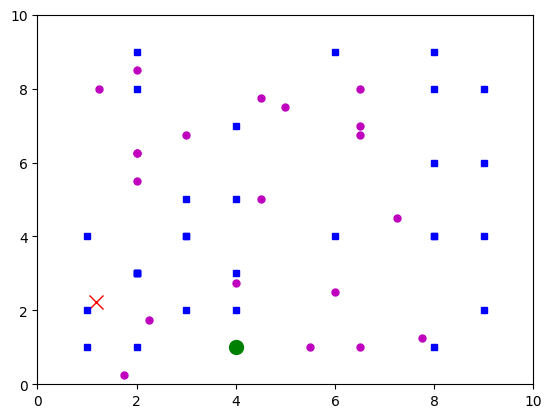

Model saved at step 28672 to Train\Saved_Models\model_step_28672.zip
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 999         |
|    ep_rew_mean          | -3.08e+04   |
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 14          |
|    time_elapsed         | 4497        |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.045800783 |
|    clip_fraction        | 0.446       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.907       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.68e+04    |
|    n_updates            | 13000       |
|    policy_gradient_loss | -0.0861     |
|    value_loss           | 1.8e+04     |
-----------------------------------------


In [25]:
model.learn(total_timesteps=1000000, callback=combined_callback)